## Nufin task for forecasting of payments:

### Data preprocessing:

In [1]:
## Importing required packages:
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import time
import operator
import json

from datetime import datetime
from dateutil.relativedelta import relativedelta
from datetime import date

from matplotlib import cm
import pmdarima as pm

import warnings
warnings.filterwarnings("ignore")

import functions as f

In [2]:
## Uploading requried data:
df = pd.read_csv("Company_1_TX_Balance_Forecasting.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3201 entries, 0 to 3200
Data columns (total 5 columns):
Company         3201 non-null int64
booking_date    3201 non-null object
amount          3201 non-null float64
balance         2327 non-null float64
tags            3201 non-null object
dtypes: float64(2), int64(1), object(2)
memory usage: 125.1+ KB


In [4]:
## We see that the "balance" column has some missing data:
df.nunique()

Company            1
booking_date      83
amount          2504
balance         2326
tags              23
dtype: int64

In [5]:
## Adjusting the date column:
df['booking_date'] = pd.to_datetime(df['booking_date'],infer_datetime_format=True).dt.date

In [6]:
"""
We also observe that there are mostly 2 groups of TCs - expenditures and revenues
and most of them are the first word in column "tags".
Let's check it:
"""
df['tags'] = df['tags'].str.replace('[','')
df['tags'] = df['tags'].str.replace(']','')

df['check_tags'] = df.tags.str.split().str.get(0)
df['check_tags'] = df['check_tags'].str.replace(',','')
df['check_tags'].unique()

array(['revenue', 'expenditure', 'leasing', 'insurance'], dtype=object)

In [7]:
## The assumption was correct, let's check insurance and leasing TCs:
df[df['check_tags'].isin(['insurance', 'leasing'])]

,Company,booking_date,amount,balance,tags,check_tags
540,1,2019-10-04,-249.08,1401301.23,"leasing, expenditure, material-supply",leasing
1310,1,2019-11-06,-249.08,886556.16,"leasing, expenditure, material-supply",leasing
2045,1,2019-12-04,-279.08,924256.10,"leasing, expenditure, material-supply",leasing
2546,1,2019-12-20,-658.86,NaN,"insurance, expenditure, material-supply",insurance
3106,1,2020-01-07,-249.08,NaN,"leasing, expenditure, material-supply",leasing


In [8]:
# Mapping them to expenditures and create a new column with tags:
df['check_tags'] = df['check_tags'].map({'insurance': 'expenditure',
                                      'leasing': 'expenditure',
                                      'expenditure':'expenditure',
                                      'revenue':'revenue'})

df['check_tags'].unique()

array(['revenue', 'expenditure'], dtype=object)

In [9]:
## Checking the range of values of only revenues (are they only positive or not)
df_revenue = df[df['check_tags'] == 'revenue']
df_revenue.describe()

,Company,amount,balance
count,1044.0,1044.000000,7.570000e+02
mean,1.0,6762.426858,1.217958e+06
std,0.0,18919.602428,3.405169e+05
min,1.0,0.100000,6.693104e+05
25%,1.0,1326.077500,9.347527e+05
50%,1.0,3224.320000,1.189203e+06
75%,1.0,6805.395000,1.450453e+06
max,1.0,399250.360000,2.227105e+06


In [10]:
## Checking the range of values of only expenditures (are they only negative or not)
df_expenditure = df[df['check_tags']=='expenditure']
df_expenditure.describe()

,Company,amount,balance
count,2157.0,2157.000000,1.570000e+03
mean,1.0,-3801.159722,1.330737e+06
std,0.0,13300.738270,3.903954e+05
min,1.0,-319813.860000,6.643865e+05
25%,1.0,-3070.000000,9.766304e+05
50%,1.0,-1011.000000,1.343854e+06
75%,1.0,-75.000000,1.507576e+06
max,1.0,-0.030000,2.227101e+06


In [11]:
# Let's take a look how many different separate tags do we have:
df['tags'] = df['tags'].str.replace(' ','')
df['tags'] = df['tags'].str.replace(',',' ')
out = ' '.join(df["tags"]).split()
tags_list = list(dict.fromkeys(out))
print(tags_list)
print("Number of unqiue tags is: ", str(len(tags_list)))

['revenue', 'sales', 'chargeback', 'expenditure', 'administration', 'material-supply', 'credit-card', 'credit', 'rent', 'salary', 'law', 'tax', 'cash', 'transport', 'salary-extra-costs', 'leasing', 'deposit', 'insurance']
Number of unqiue tags is:  18


In [12]:
"""
We could create separate groups for each identical group of tags to see whether we have it might make sense
to do the separate forecasting for each of these groups. 
"""

df['tags'] = df['tags'].str.replace(' ','_')
out = ' '.join(df["tags"]).split()
merged_tags_list = list(dict.fromkeys(out))
print(merged_tags_list)
print("Number of unqiue groups of tags is: ", str(len(merged_tags_list)))

['revenue', 'revenue_sales', 'revenue_chargeback_sales', 'expenditure', 'expenditure_administration_material-supply', 'expenditure_credit-card_credit_material-supply', 'expenditure_rent', 'expenditure_material-supply', 'expenditure_salary_material-supply', 'expenditure_credit-card', 'expenditure_law_tax_material-supply', 'expenditure_credit_material-supply', 'expenditure_material-supply_cash', 'expenditure_administration_credit_material-supply', 'expenditure_transport_material-supply', 'expenditure_tax_salary-extra-costs_salary_material-supply', 'leasing_expenditure_material-supply', 'expenditure_tax', 'revenue_credit', 'expenditure_credit-card_material-supply', 'revenue_chargeback_rent', 'revenue_deposit', 'insurance_expenditure_material-supply']
Number of unqiue groups of tags is:  23


In [13]:
## Checking how many days of TCs has each group and compare it with a total number of available dates:
df_groups_forecast = df.groupby(['booking_date', 'tags']).agg({'amount':'count'})
df_groups_forecast = f.index_groupby(df_groups_forecast, ['booking_date', 'tags'])
df_groups_forecast = df_groups_forecast.rename(columns = {'amount':'tc_number'})
df_groups_forecast = df_groups_forecast.groupby(['tags']).agg({'tc_number':'nunique'})
print(df_groups_forecast)
dates_number = df['booking_date'].nunique()
print("Number of available dates: " + str(dates_number))

                                                    tc_number
tags                                                         
expenditure                                                14
expenditure_administration_credit_material-supply           1
expenditure_administration_material-supply                  2
expenditure_credit-card                                     1
expenditure_credit-card_credit_material-supply              1
expenditure_credit-card_material-supply                     1
expenditure_credit_material-supply                          5
expenditure_law_tax_material-supply                         2
expenditure_material-supply                                39
expenditure_material-supply_cash                            1
expenditure_rent                                            1
expenditure_salary_material-supply                          1
expenditure_tax                                             1
expenditure_tax_salary-extra-costs_salary_mater...          1
expendit

In [14]:
## Introduction of new column "balance_check", since it seems that the data is flawed
df['balance_check'] = 0
df['balance_check'][0] = df['balance'][0]
df['balance_check'][1:] = df['balance'][0] + np.cumsum(df['amount'][1:])


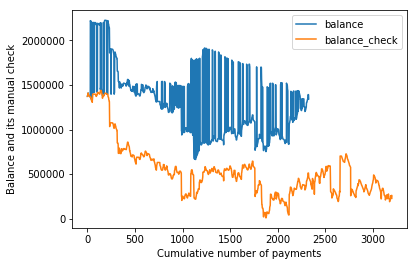

In [15]:
## Building the plot of balances to see that there is an obvious mismatch:
fig, ax = plt.subplots()
ax.plot(df['balance'])
ax.plot(df['balance_check'])

ax.set(xlabel = 'Cumulative number of payments')
ax.set(ylabel = 'Balance and its manual check')
ax.legend(loc = 'upper_right')


In [16]:
df.nunique()

Company             1
booking_date       83
amount           2504
balance          2326
tags               23
check_tags          2
balance_check    3201
dtype: int64

In [17]:
"""
From here we drop columns 'Company', 'Balance' and 'Tags', since we can't use the grouped tags and would simply
either forecast revenues and expenditures together (aggregating them beforehand) or forecast them separately 
and then sum up forecasts. Anyway, we just need to add resulting number to balance at the end to get the answer:
"""
df = df.drop(['Company', 'balance', 'tags'], axis = 1)
df = df.rename(columns = {'balance_check':'balance'})

### Forecasting part (case when we treat all transactions together):

In [18]:
"""
Here you need to specify the number of days for which you would like to have your forecast
I decided not to restrict artificailly the range from 1 to 10, it could be simply added with an if loop. I wanted
to play around with different numbers for forecasting in order to see how models behave in short / long-term.
""" 
forecast_days = 10

In [19]:
"""
As we stated previously, let us first get the balance values for each of days and aggregate amounts on days:
"""
df_total_forecast = df.groupby(['booking_date']).agg({'amount':'sum'})
df_total_balance = df.groupby(['booking_date']).agg({'balance': 'last'})


In [20]:
"""
After launching all the models, would like to add a comment here at very beginning:
I have tried to switch to growth rates, but then further results suggest 
ARIMA (0, 0, 0) x (0, 0, 1, 28) as the best model, which makes no sense in terms of growth rates.

I've tried to change different weekly seasonalities (7, 14, 21, 28, see function select_estimated_models for it),
but due to the insufficient dataset, sometimes models are not able to build a prediction with high seasonalities.

I also even tried to exclude huge growth rates (abs >15), under assumption that we need more data to model 
these peaks, but this also deliveres flawed models with only a constant parameter.
That's why I would like to leave the original data, since stationarity tests do not require additional difference
in 2 of 3 cases later on. However, there is a room for further analysis and improvement. 

df_total_forecast['amount'] = df_total_forecast['amount'].pct_change()
df_total_forecast = df_total_forecast.dropna()
df_total_forecast.describe()
"""

"\nAfter launching all the models, would like to add a comment here at very beginning:\nI have tried to switch to growth rates, but then further results suggest \nARIMA (0, 0, 0) x (0, 0, 1, 28) as the best model, which makes no sense in terms of growth rates.\n\nI've tried to change different weekly seasonalities (7, 14, 21, 28, see function select_estimated_models for it),\nbut due to the insufficient dataset, sometimes models are not able to build a prediction with high seasonalities.\n\nI also even tried to exclude huge growth rates (abs >15), under assumption that we need more data to model \nthese peaks, but this also deliveres flawed models with only a constant parameter.\nThat's why I would like to leave the original data, since stationarity tests do not require additional difference\nin 2 of 3 cases later on. However, there is a room for further analysis and improvement. \n\ndf_total_forecast['amount'] = df_total_forecast['amount'].pct_change()\ndf_total_forecast = df_total_fo

In [21]:
### df_total_forecast = df_total_forecast[np.abs(df_total_forecast['amount']) < 15]

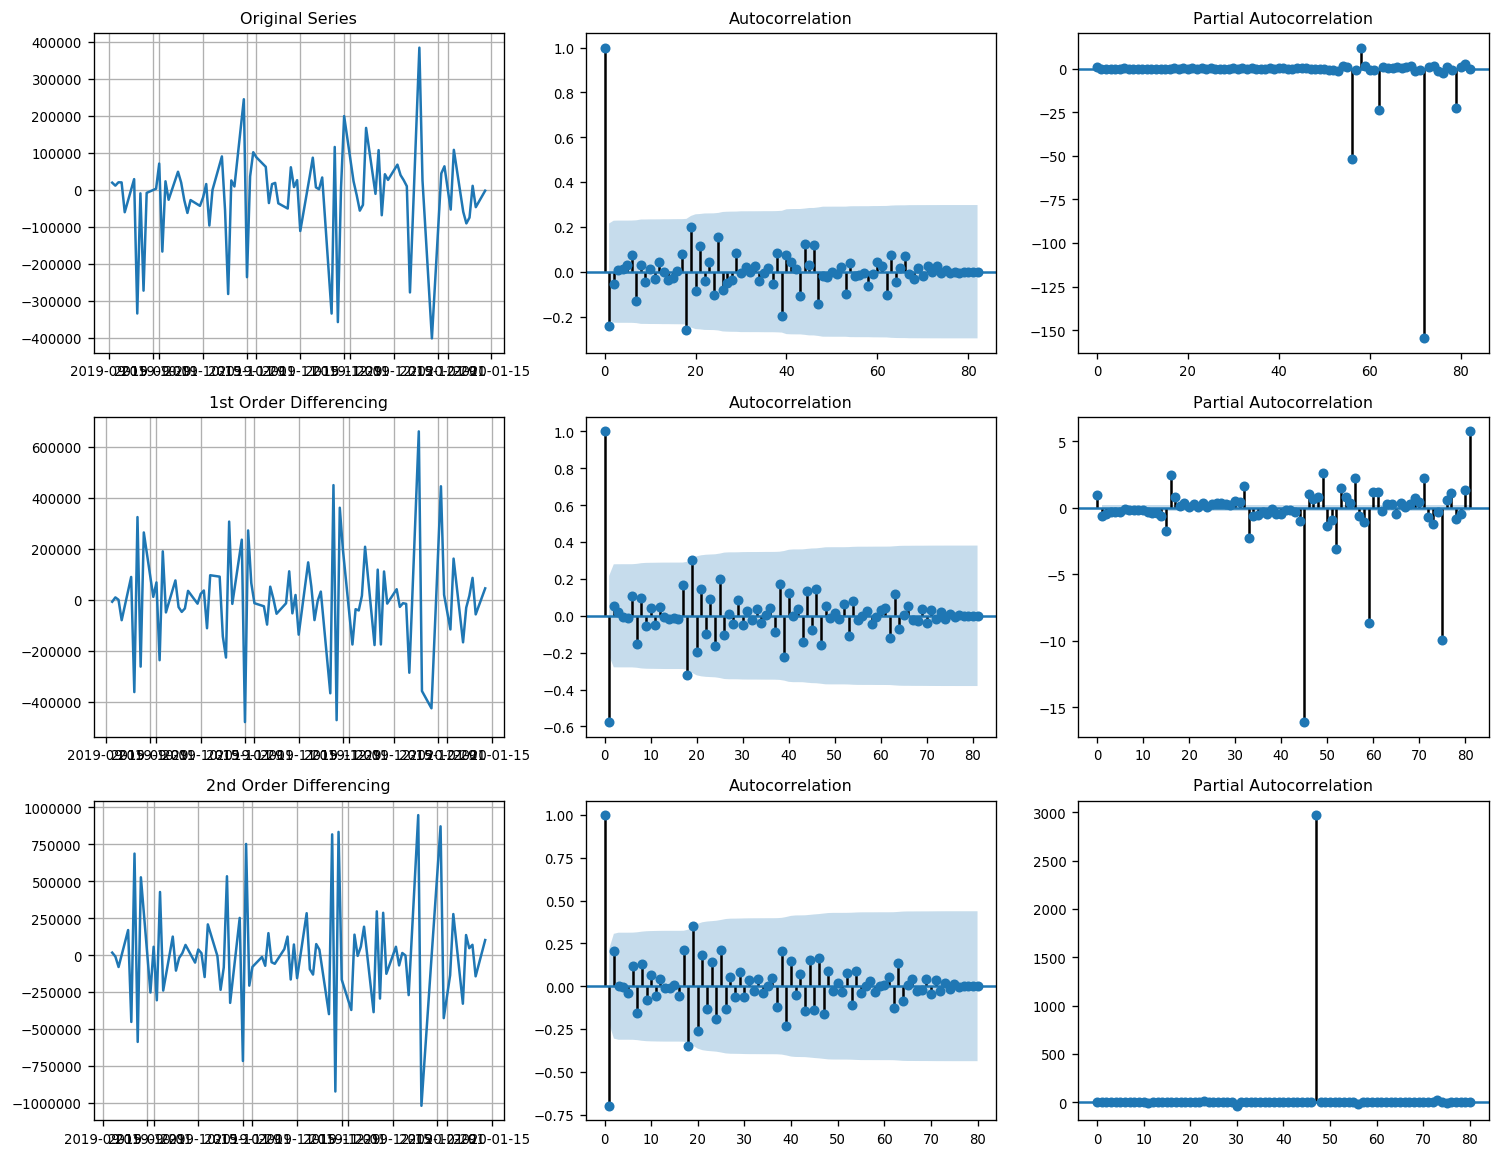

In [22]:
## Taking a look at the differences graphs:
f.diff_graphs(data = df_total_forecast, show_graph = True, save_graph = False)

In [23]:
## Checking tests, seems that there is no need to adjust the differences:
f.stationarity_tests(data = df_total_forecast)

{'usual_differencing': {'ADF_test': 0, 'KPSS_test': 0, 'PP_test': 0},
 'seasonal_differencing': {'Canova-Hansen': 0, 'OCSB': 0}}

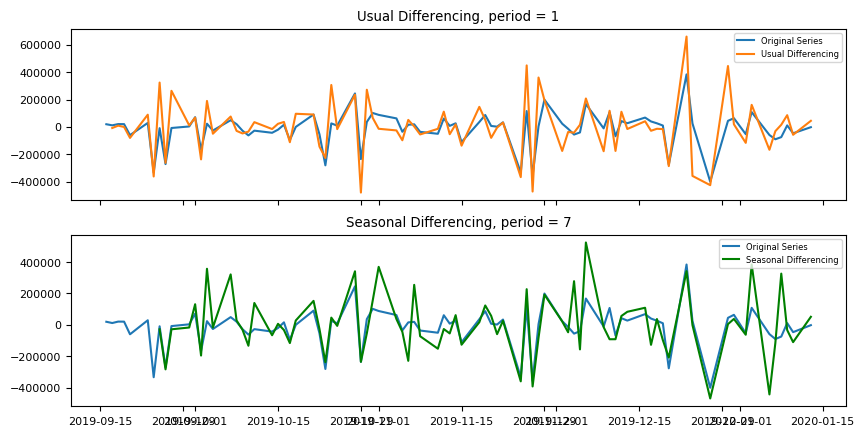

In [24]:
"""
Checking for potential seasonal differences (looking at original time series 
there is no clear tendence, but let us take a look at 7 and 30 days)
""" 
f.seasonal_diff_graphs(data = df_total_forecast, show_graph = True, save_graph = False,
                       season_diff_number = 7)

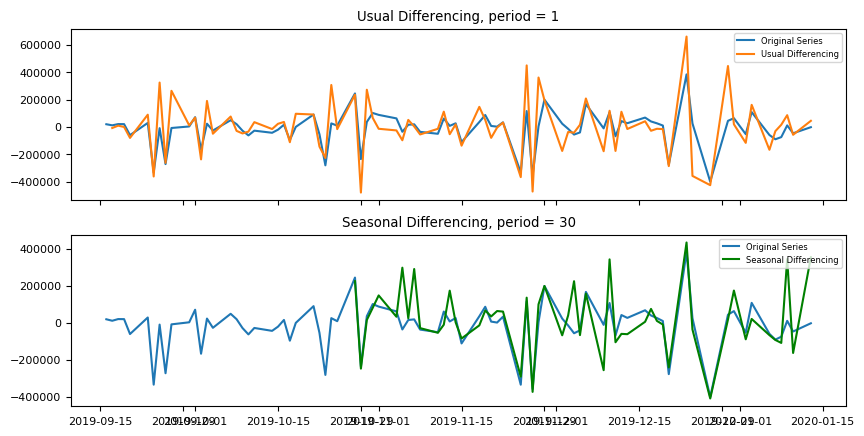

In [25]:
f.seasonal_diff_graphs(data = df_total_forecast, show_graph = True, save_graph = False,
                       season_diff_number = 30)

In [26]:
"""
Let's take a look at the first try with auto_arima ans since we don't see any clear seasonal differences,
let's skip all the possible integrational and seasonal differences to use ARIMA model as a benchmark:
"""

model = pm.auto_arima(df_total_forecast, start_p = 0, start_q = 0,
                      test = 'kpss', max_p = 12, max_q = 12, 
                      m = 1, d = None, seasonal = True,start_P = 0,
                      start_Q = 0, D = None, trace = True, 
                      error_action = 'ignore', suppress_warnings = True,
                      stepwise = True, information_criteria = 'bic')
print(model.summary())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=2185.900, BIC=2190.738, Fit time=0.008 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=2182.872, BIC=2190.129, Fit time=0.011 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=2182.316, BIC=2189.573, Fit time=0.010 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=2184.448, BIC=2194.123, Fit time=0.017 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=2184.473, BIC=2194.148, Fit time=0.014 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=2185.649, BIC=2197.743, Fit time=0.030 seconds
Total fit time: 0.092 seconds
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   83
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -1088.158
Date:                Mon, 24 Feb 2020   AIC                           2182.316
Time:       

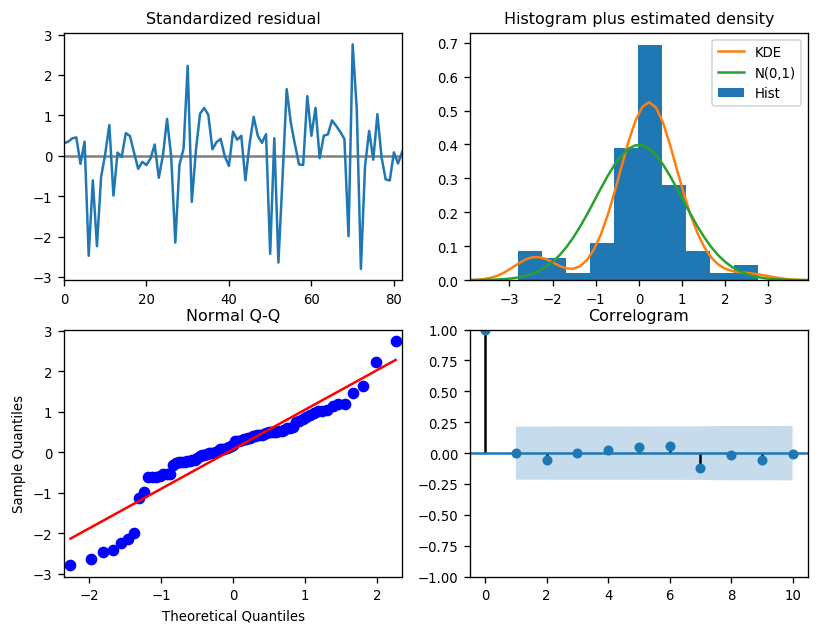

In [27]:
## Building the residual / density /  Q-Q / Correlogram for the benchmark:
model.plot_diagnostics(figsize = (8,6))
plt.show()
model_config = model.to_dict()

In [28]:
"""
Here we use brute force method to check all the possible parameters and now select / save the model with best MAE.
We also take the benchmark to compare the results and if it gives better MAE, we select it
""" 
params_list = f.select_estimated_models(max_p = 3, max_d = 0, max_q = 3,
                          max_P = 3, max_D = 0, max_Q = 3,
                          season_number = 7, season_number_ints = 2)
start_time = time.time()
best_model = f.models_selection(data = df_total_forecast,
                     params_list = params_list,
                     bic_model = model_config ,
                     selection_metric = 'mae',
                     testing_ratio = 0.25,
                     save_graph = False, 
                     show_graph = False)
print("Time required for the selection of the best model: --- %s seconds ---" % (time.time() - start_time))


The model (2, 0, 1)x (1, 0, 1, 7)can't be estimated due to invertibility condition
The model (2, 0, 1)x (1, 0, 2, 14)can't be estimated due to invertibility condition
The model (2, 0, 1)x (1, 0, 1, 14)can't be estimated due to invertibility condition
The model (2, 0, 1)x (1, 0, 2, 7)can't be estimated due to invertibility condition
Time for brute selection of models: --- 2.117041826248169 seconds ---
Time required for the selection of the best model: --- 2.1502020359039307 seconds ---


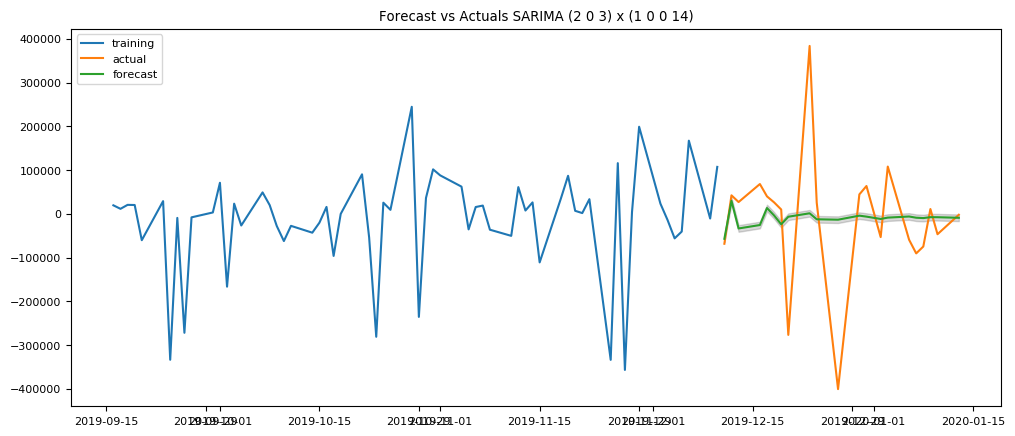

{'mae': 89884.72800831895,
 'rmse': 142205.7227862054,
 'corr': 0.1843153933216016,
 'minmax': -4.289551413917887}

In [29]:
"""
Out-of-scope validation: Just to take a look how our best selected model would work on some train set
and then performs on a test set. let's split the data in 2 parts with ratio 0.25 and take a look at the graph
"""

f.forecasting_metrics(df_total_forecast,
                    best_model['best_model_params'][0], 
                    best_model['best_model_params'][1],
                    save_graph = False, 
                    show_graph = True, 
                    testing_ratio = 0.25)

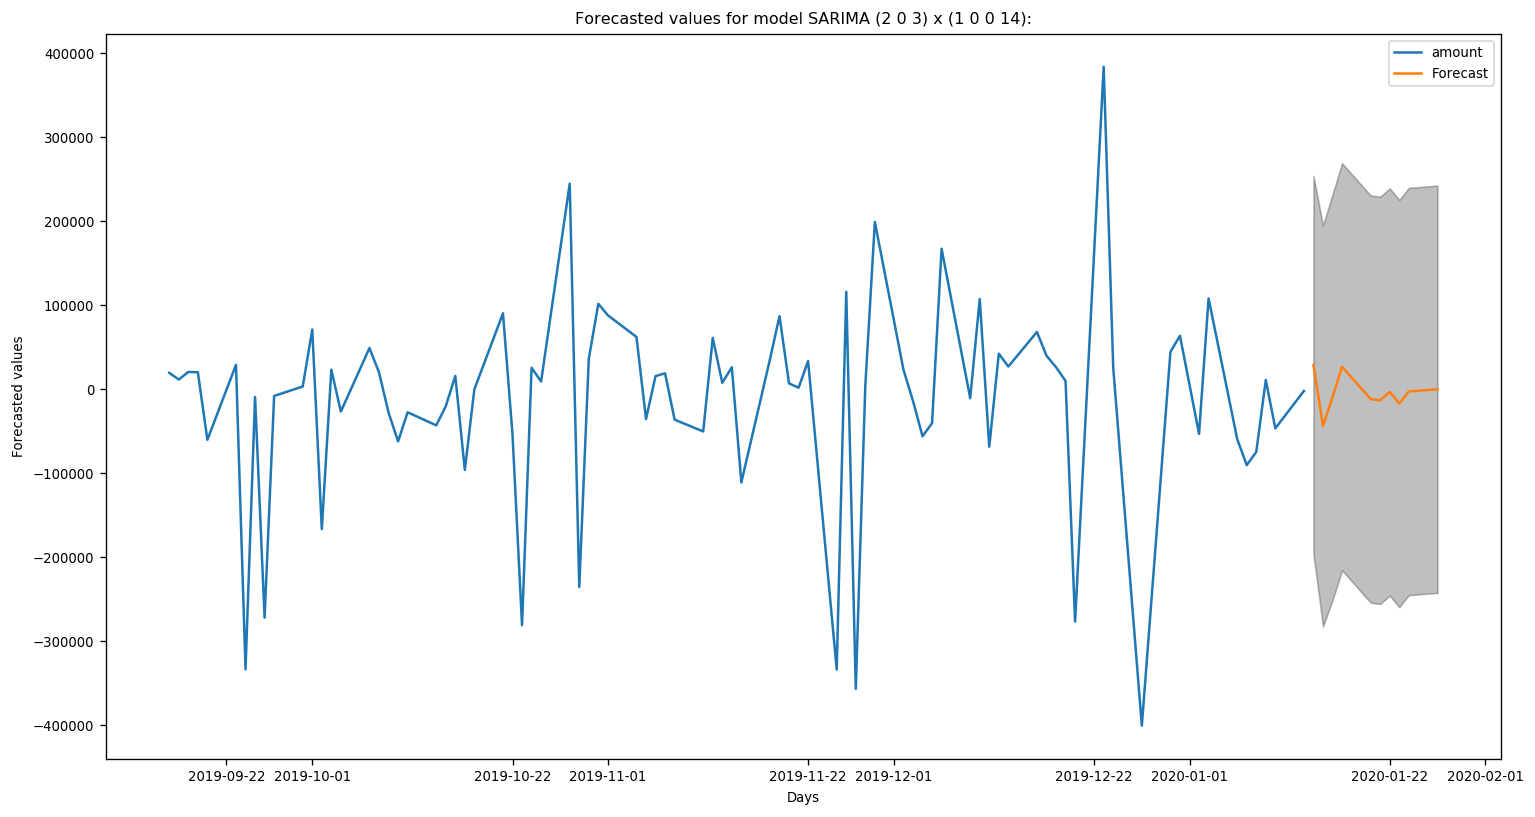

In [30]:
## Here we would use the forecast length based on the number of days for which we would like to forecast the TCs:
forecasted_ts = f.final_forecasting(data = df_total_forecast,
                                    forecast_periods = forecast_days,
                                    best_model_dict = best_model,
                                    save_graph = False,
                                    show_graph = True)

In [31]:
## printing the vector of new balances:
new_balances_vector =  df_total_balance['balance'].iloc[len(df_total_balance) -1] + np.cumsum(forecasted_ts['forecasted_values'])
total_balances = pd.DataFrame(new_balances_vector, columns = ['forecasted_balances'])
total_balances

,forecasted_balances
2020-01-14,256116.445848
2020-01-15,212285.057163
2020-01-16,202891.905178
2020-01-17,229595.251775
2020-01-20,217814.617734
2020-01-21,204604.459376
2020-01-22,201329.494210
2020-01-23,184224.898820
2020-01-24,181498.144873
2020-01-27,181453.103407


### Forecasting part (case when we treat expenditures and revenues separately):

In [32]:
"""
As we stated previously, we aggregate amounts on days:
"""
df_expend = df[df['check_tags'] == 'expenditure']
df_expend_forecast = df_expend.groupby(['booking_date']).agg({'amount':'sum'})

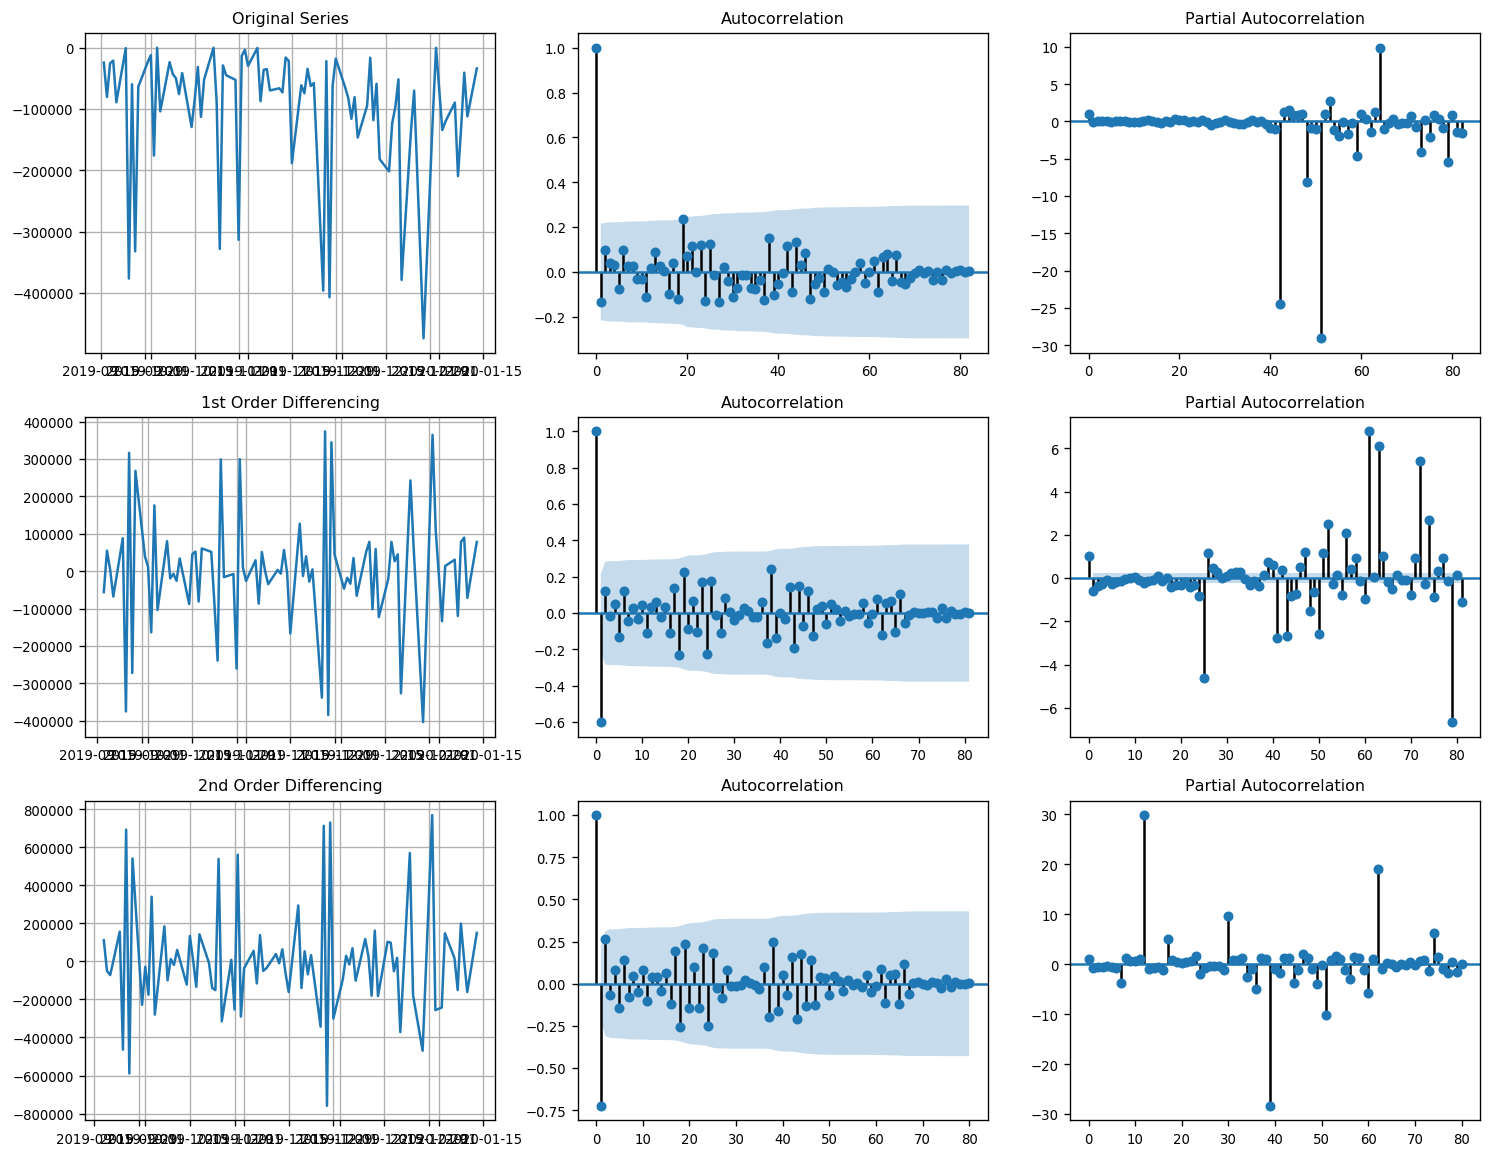

In [33]:
## Taking a look at the differences graphs:
f.diff_graphs(data = df_expend_forecast, show_graph = True, save_graph = False)

In [34]:
## Checking stationarity tests, seems that there is no need to adjust the differences:
f.stationarity_tests(data = df_expend_forecast)

{'usual_differencing': {'ADF_test': 0, 'KPSS_test': 0, 'PP_test': 0},
 'seasonal_differencing': {'Canova-Hansen': 0, 'OCSB': 0}}

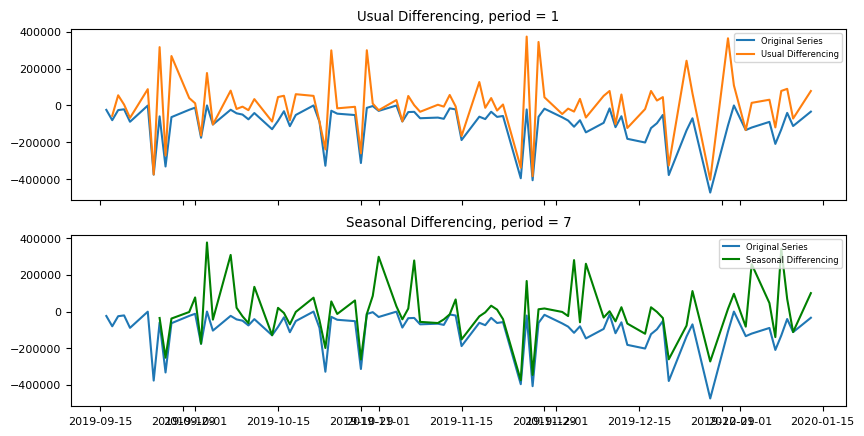

In [35]:
"""
Visually checking for potential seasonal differences (looking at original time series 
there is no clear tendence, but let us take a look at 7 and 30 days)
""" 
f.seasonal_diff_graphs(data = df_expend_forecast, show_graph = True, save_graph = False,
                       season_diff_number = 7)

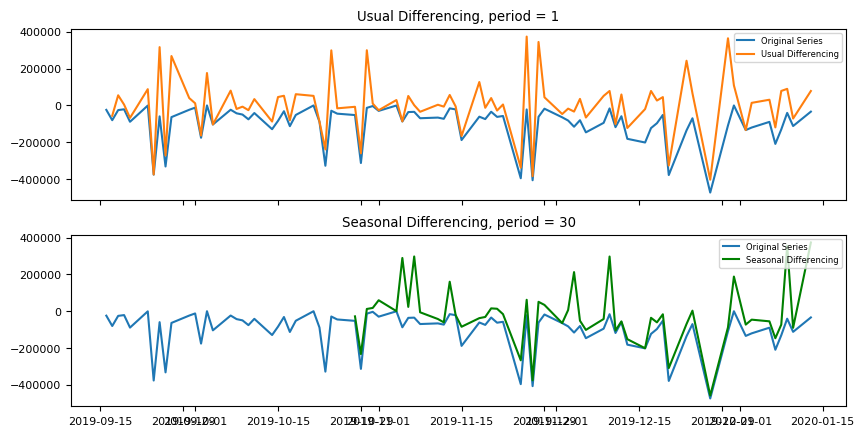

In [36]:
f.seasonal_diff_graphs(data = df_expend_forecast, show_graph = True, save_graph = False,
                       season_diff_number = 30)

In [37]:
"""
Let's take a look at the first try with auto_arima ans since we don't see any clear seasonal differences,
let's skip all the possible integrational and seasonal differences to use ARIMA model as a benchmark:
"""

model_exp = pm.auto_arima(df_expend_forecast, start_p = 0, start_q = 0,
                      test = 'kpss', max_p = 12, max_q = 12, 
                      m = 1, d = None, seasonal = True,start_P = 0,
                      start_Q = 0, D = None, trace = True, 
                      error_action = 'ignore', suppress_warnings = True,
                      stepwise = True, information_criteria = 'bic')
print(model.summary())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=2156.219, BIC=2161.057, Fit time=0.007 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=2156.707, BIC=2163.963, Fit time=0.011 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=2157.428, BIC=2164.684, Fit time=0.009 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=2158.871, BIC=2168.546, Fit time=0.016 seconds
Total fit time: 0.047 seconds
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   83
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -1088.158
Date:                Mon, 24 Feb 2020   AIC                           2182.316
Time:                        14:17:18   BIC                           2189.573
Sample:                             0   HQIC                          2185.232
                                 - 83                               

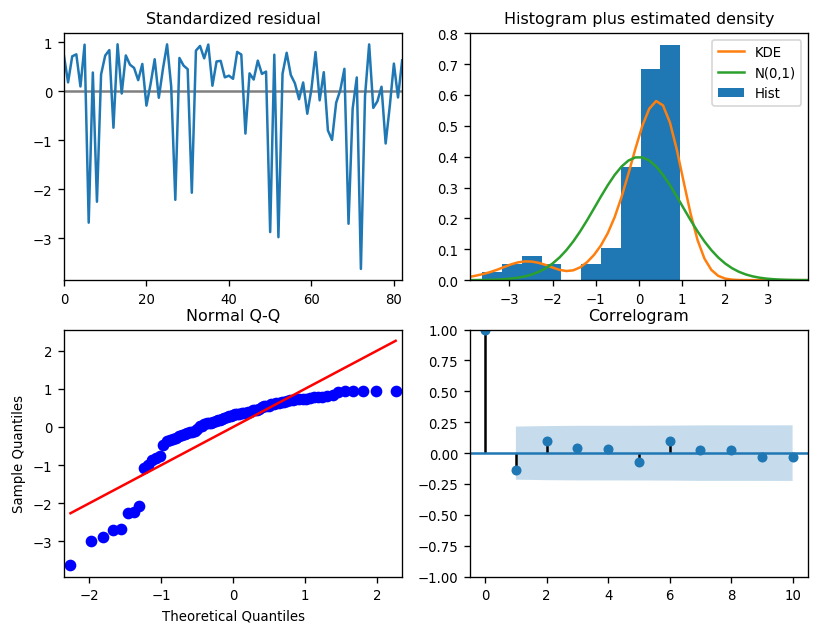

In [38]:
## Building the residual / density /  Q-Q / Correlogram for the benchmark
model_exp.plot_diagnostics(figsize = (8,6))
plt.show()
model_exp_config = model_exp.to_dict()

In [39]:
"""
Here we use brute force method to check all the possible parameters and now select / save the model with best RMSE.
We also take the benchmark to compare the results and if it gives better RMSE, we select it
Here I am using
""" 
params_list = f.select_estimated_models(max_p = 3, max_d = 0, max_q = 3,
                          max_P = 3, max_D = 0, max_Q = 3,
                          season_number = 7, season_number_ints = 4)
start_time = time.time()
best_model_exp = f.models_selection(data = df_expend_forecast,
                     params_list = params_list,
                     bic_model = model_exp_config ,
                     selection_metric = 'mae',
                     testing_ratio = 0.25,
                     save_graph = False, 
                     show_graph = False)
print("Time required for the selection of the best model: --- %s seconds ---" % (time.time() - start_time))



Time for brute selection of models: --- 3.46301007270813 seconds ---
Time required for the selection of the best model: --- 3.4992449283599854 seconds ---


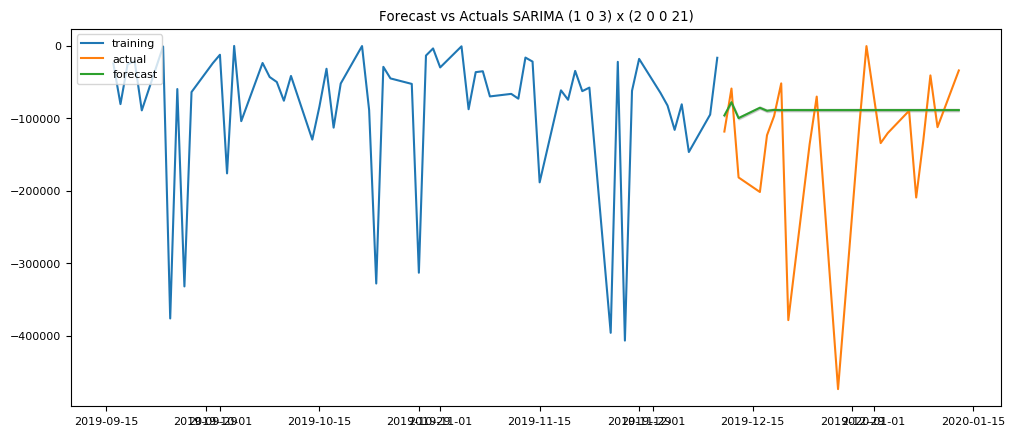

{'mae': 73119.83681995719,
 'rmse': 117969.228869047,
 'corr': 0.11347006347693957,
 'minmax': -14.88538681391172}

In [40]:
"""
Out-of-scope validation: Just to take a look how our best selected model would work on some train set
and then performs on a test set. let's split the data in 2 parts with ratio 0.25 and take a look at the graph
"""

f.forecasting_metrics(df_expend_forecast,
                    best_model_exp['best_model_params'][0], 
                    best_model_exp['best_model_params'][1],
                    save_graph = False, 
                    show_graph = True, 
                    testing_ratio = 0.25)

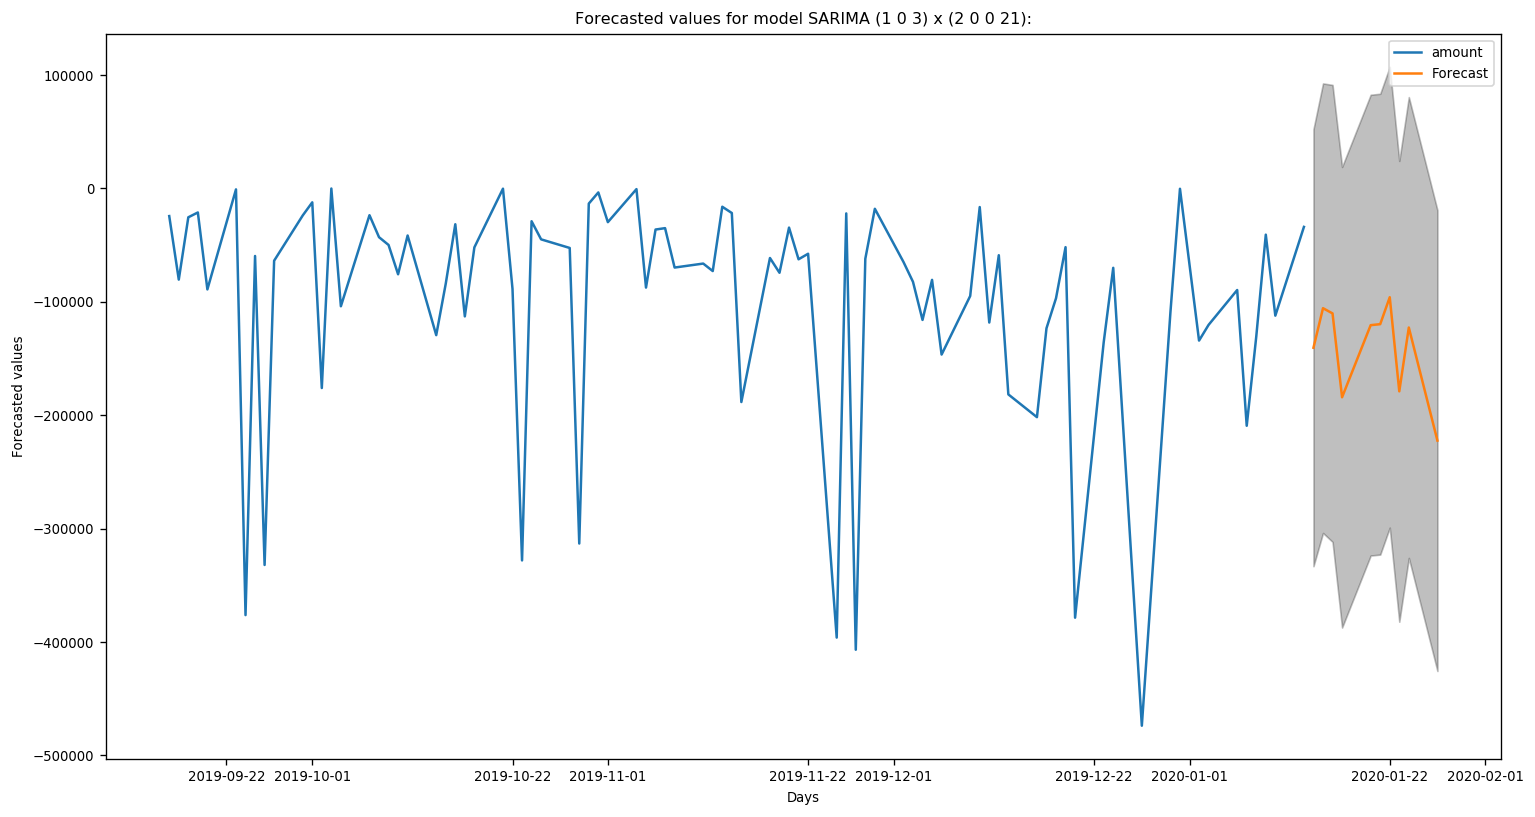

In [41]:
## Here we would use the forecast length based on the number of days for which we would like to forecast the TCs:
forecasted_ts_exp = f.final_forecasting(data = df_expend_forecast,
                                    forecast_periods = forecast_days,
                                    best_model_dict = best_model_exp,
                                    save_graph = False,
                                    show_graph = True)

In [42]:
## vector of new expenditures:
forecasted_exp = forecasted_ts['forecasted_values']
forecasted_exp

2020-01-14    28763.325848
2020-01-15   -43831.388685
2020-01-16    -9393.151985
2020-01-17    26703.346597
2020-01-20   -11780.634041
2020-01-21   -13210.158358
2020-01-22    -3274.965166
2020-01-23   -17104.595390
2020-01-24    -2726.753947
2020-01-27      -45.041466
dtype: float64

In [43]:
## Now absolutely same for revenues:
"""
As we stated previously, we aggregate amounts on days:
"""
df_rev = df[df['check_tags'] == 'revenue']
df_rev_forecast = df_rev.groupby(['booking_date']).agg({'amount':'sum'})

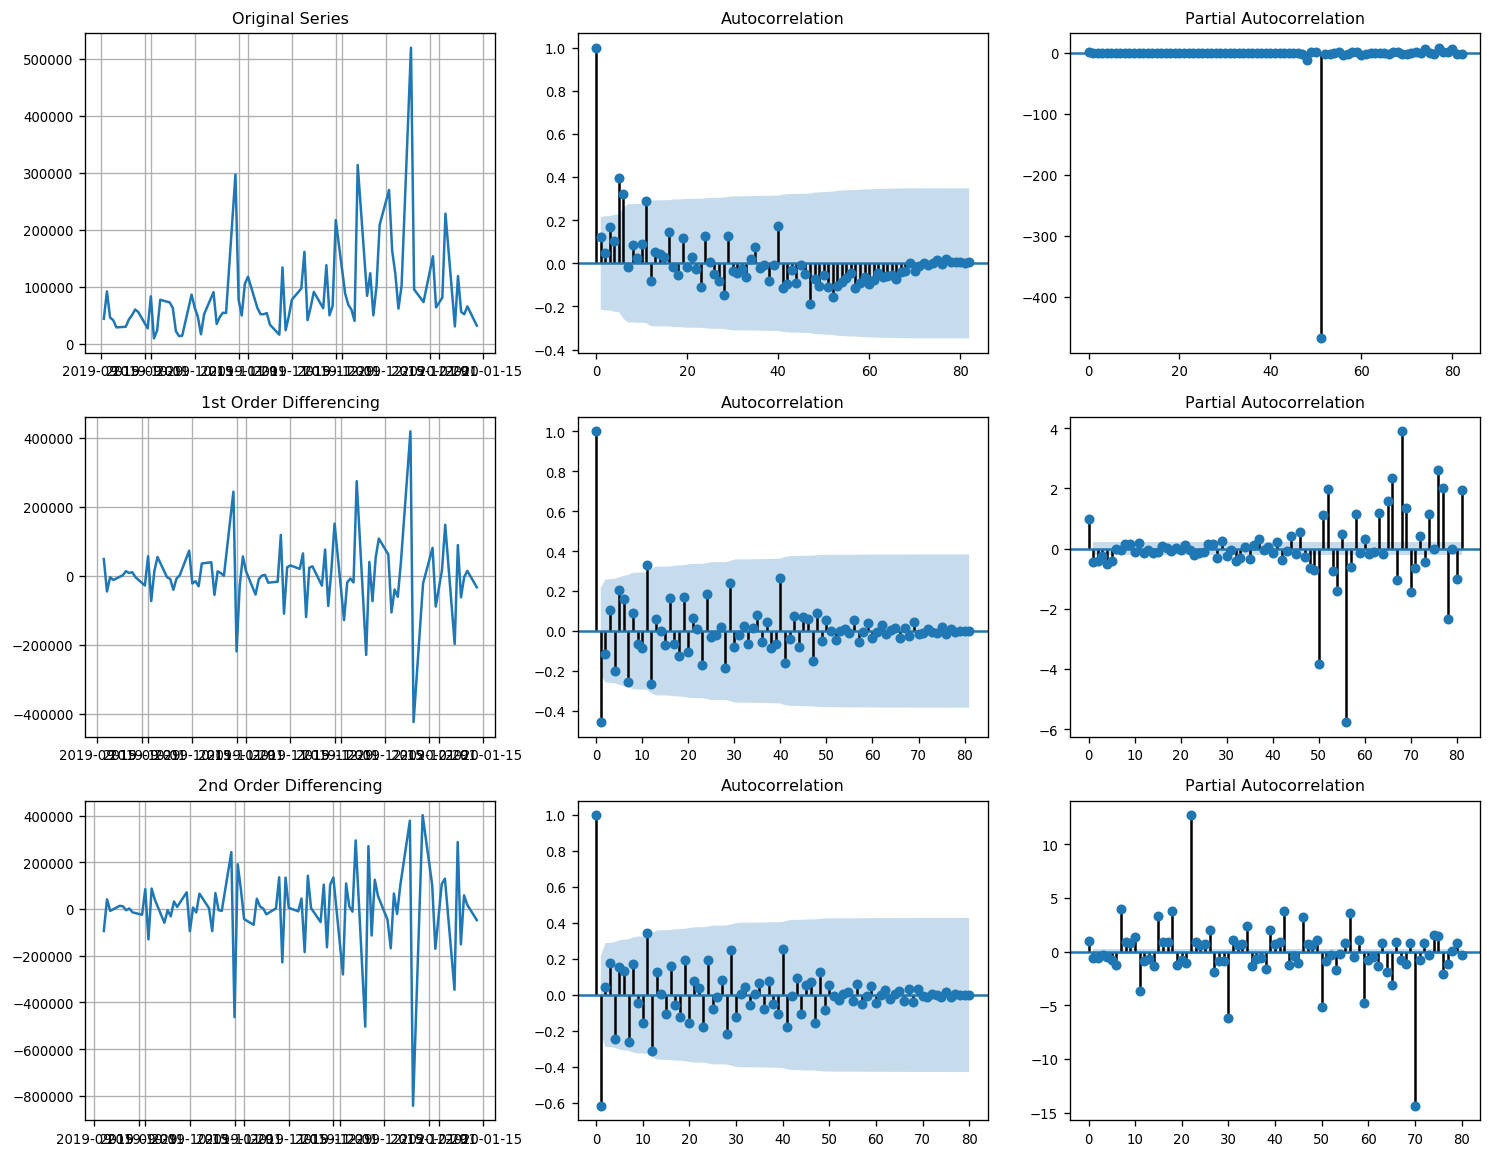

In [44]:
## Taking a look at the differences graphs:
f.diff_graphs(data = df_rev_forecast, show_graph = True, save_graph = False)

In [45]:
## Checking stationarity tests, seems that we need to adjust the differences:
f.stationarity_tests(data = df_rev_forecast)

{'usual_differencing': {'ADF_test': 1, 'KPSS_test': 1, 'PP_test': 0},
 'seasonal_differencing': {'Canova-Hansen': 0, 'OCSB': 0}}

In [46]:
## Adjusting the differences, dropping missing values:
df_rev_forecast = df_rev_forecast.diff()
df_rev_forecast = df_rev_forecast.dropna()

In [47]:
# doing stationarity testing again:
f.stationarity_tests(data = df_rev_forecast)

{'usual_differencing': {'ADF_test': 0, 'KPSS_test': 0, 'PP_test': 0},
 'seasonal_differencing': {'Canova-Hansen': 0, 'OCSB': 0}}

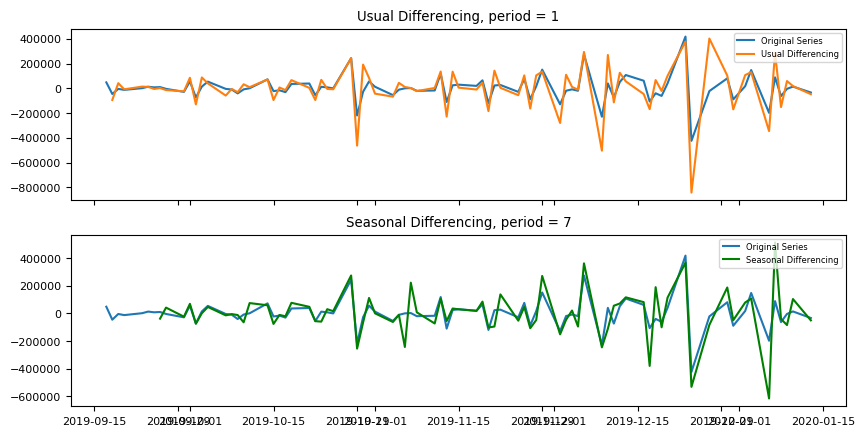

In [48]:
"""
Visually checking for potential seasonal differences (looking at original time series 
there is no clear and obvious tendence, but let us take a look at 7 and 30 days)
""" 
f.seasonal_diff_graphs(data = df_rev_forecast, show_graph = True, save_graph = False,
                       season_diff_number = 7)

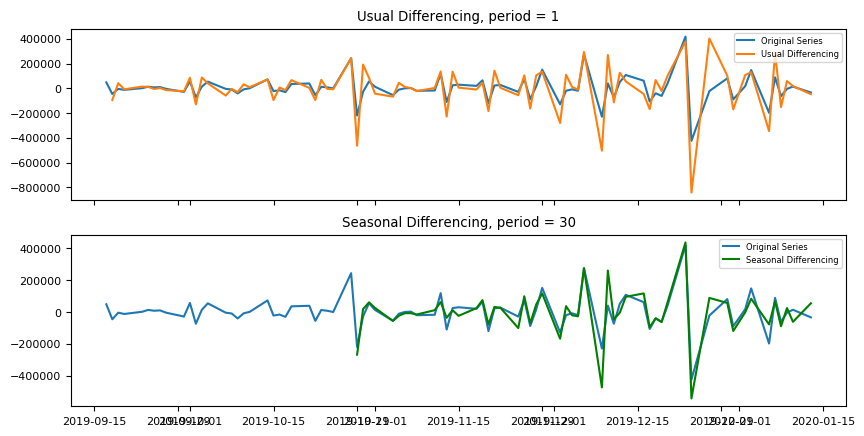

In [49]:
f.seasonal_diff_graphs(data = df_rev_forecast, show_graph = True, save_graph = False,
                       season_diff_number = 30)

In [50]:
"""
Let's take a look at the first try with auto_arima ans since we don't see any clear seasonal differences,
let's skip all the possible integrational and seasonal differences to use ARIMA model as a benchmark:
"""

model_rev = pm.auto_arima(df_rev_forecast, start_p = 0, start_q = 0,
                      test = 'kpss', max_p = 12, max_q = 12, 
                      m = 1, d = None, seasonal = True,start_P = 0,
                      start_Q = 0, D = None, trace = True, 
                      error_action = 'ignore', suppress_warnings = True,
                      stepwise = True, information_criteria = 'bic')
print(model.summary())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=2129.242, BIC=2134.055, Fit time=0.007 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=2112.273, BIC=2119.493, Fit time=0.011 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=2083.324, BIC=2090.544, Fit time=0.013 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=2085.128, BIC=2094.754, Fit time=0.020 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.057 seconds
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   83
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -1088.158
Date:                Mon, 24 Feb 2020   AIC                           2182.316
Time:                        14:17:3

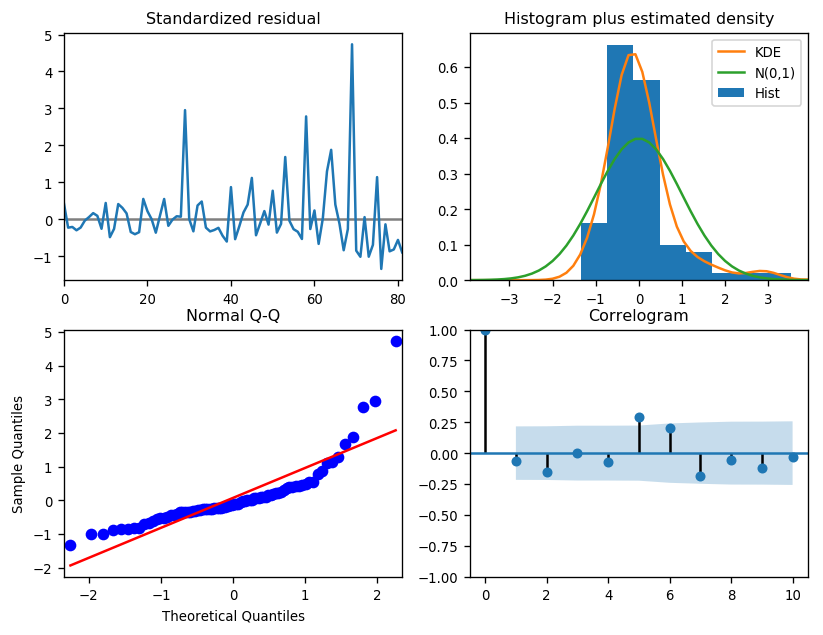

In [51]:
## Building the residual / density /  Q-Q / Correlogram for the benchmark
model_rev.plot_diagnostics(figsize = (8,6))
plt.show()
model_rev_config = model_rev.to_dict()

In [52]:
"""
Here we use brute force method to check all the possible parameters and now select / save the model with best RMSE.
We also take the benchmark to compare the results and if it gives better RMSE, we select it
Here I am using
""" 
params_list = f.select_estimated_models(max_p = 3, max_d = 0, max_q = 3,
                          max_P = 3, max_D = 0, max_Q = 3,
                          season_number = 7, season_number_ints = 2)
start_time = time.time()
best_model_rev = f.models_selection(data = df_rev_forecast,
                     params_list = params_list,
                     bic_model = model_rev_config ,
                     selection_metric = 'mae',
                     testing_ratio = 0.25,
                     save_graph = False, 
                     show_graph = False)
print("Time required for the selection of the best model: --- %s seconds ---" % (time.time() - start_time))

Time for brute selection of models: --- 2.0901880264282227 seconds ---
Time required for the selection of the best model: --- 2.1824591159820557 seconds ---


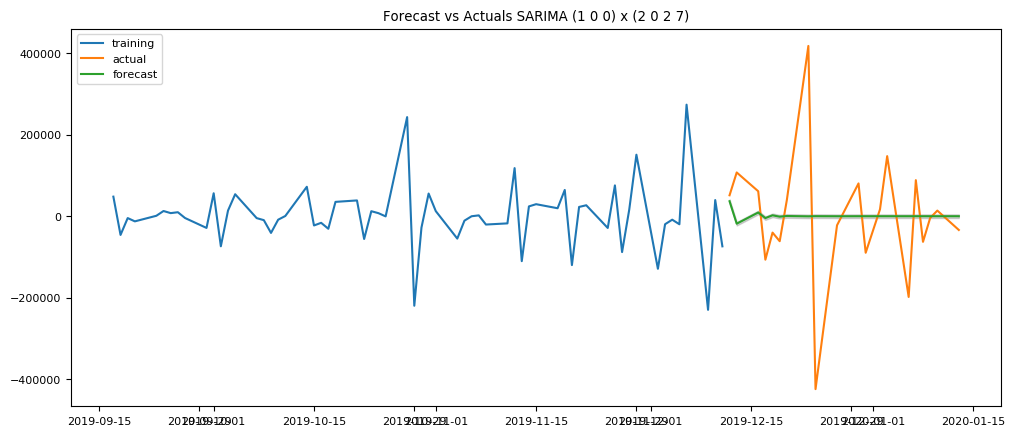

{'mae': 101878.11936710162,
 'rmse': 155016.18594509078,
 'corr': 0.028047590074119146,
 'minmax': -593.1942575258638}

In [53]:
"""
Out-of-scope validation: Just to take a look how our best selected model would work on some train set
and then performs on a test set. let's split the data in 2 parts with ratio 0.25 and take a look at the graph
"""

f.forecasting_metrics(df_rev_forecast,
                    best_model_rev['best_model_params'][0], 
                    best_model_rev['best_model_params'][1],
                    save_graph = False, 
                    show_graph = True, 
                    testing_ratio = 0.25)

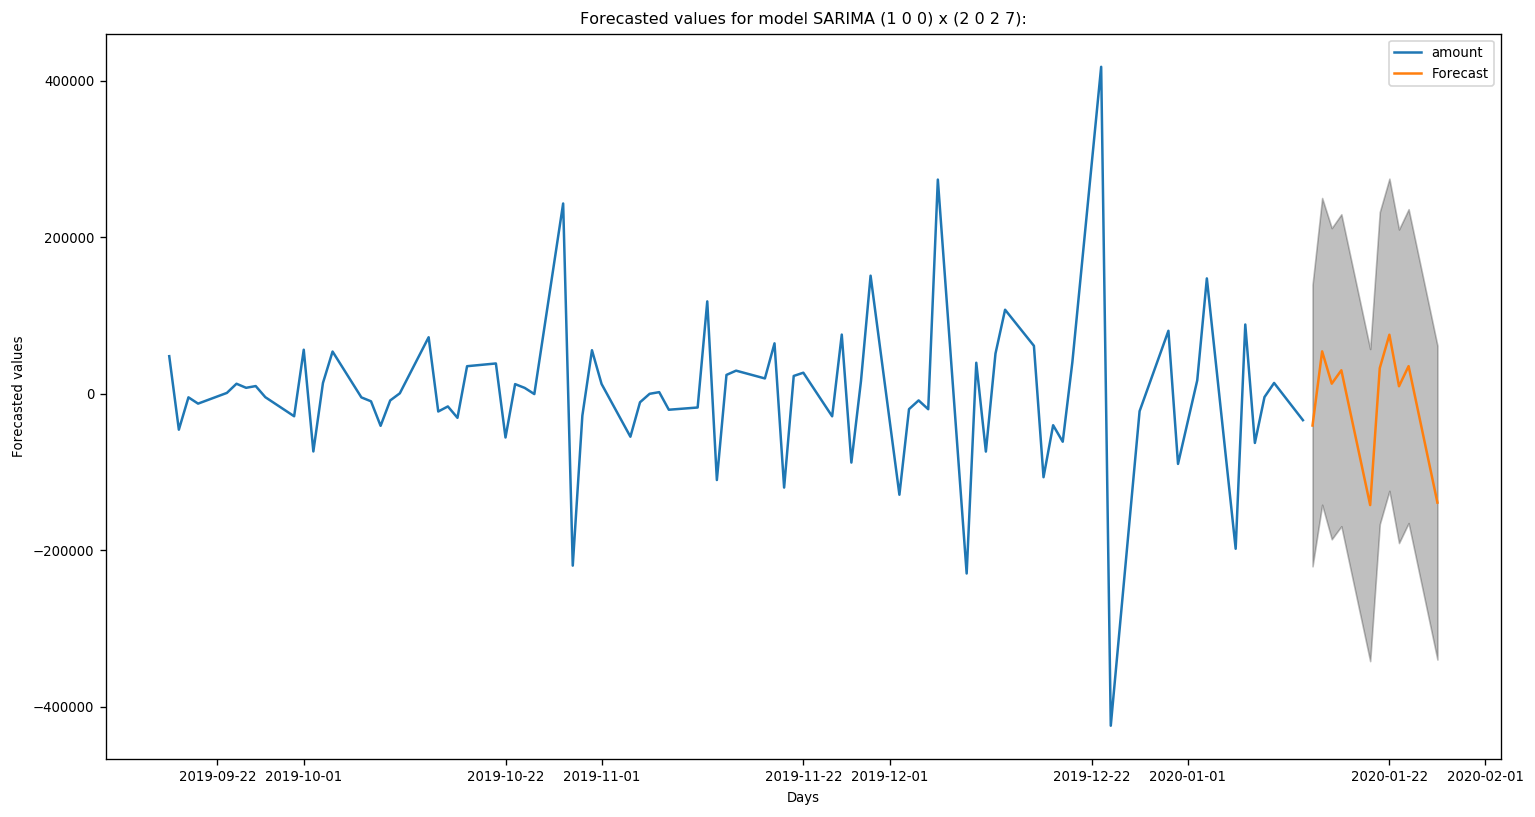

In [54]:
## Here we would use the forecast length based on the number of days for which we would like to forecast the TCs:
forecasted_ts_rev = f.final_forecasting(data = df_rev_forecast,
                                    forecast_periods = forecast_days,
                                    best_model_dict = best_model_rev,
                                    save_graph = False,
                                    show_graph = True)

In [55]:
#taking the forecasted differences and adjusting them to normal values:
forecasted_ts_rev['forecasted_values']
df_rev_forecast_old = df_rev.groupby(['booking_date']).agg({'amount':'sum'})
forecasted_rev = np.r_[df_rev_forecast_old['amount'].iloc[[len(df_rev_forecast_old)-1]], forecasted_ts_rev['forecasted_values']].cumsum()[1:]

In [56]:
## total forecasted amount of revenues and expenditures:
forecast_total_revexp = forecasted_rev + forecasted_exp
forecast_total_revexp

2020-01-14     19999.416289
2020-01-15      1602.327453
2020-01-16     48929.887468
2020-01-17    115038.482360
2020-01-20    -65738.489972
2020-01-21    -34348.543945
2020-01-22     51013.968595
2020-01-23     46773.053671
2020-01-24     96460.302848
2020-01-27    -39981.584076
dtype: float64

In [57]:
## printing the vector of new balances:
new_balances_vector_revexp =  df_total_balance['balance'].iloc[len(df_total_balance) -1] + np.cumsum(forecast_total_revexp)
total_balances_revexp = pd.DataFrame(new_balances_vector_revexp, columns = ['forecasted_balances'])
total_balances_revexp

,forecasted_balances
2020-01-14,247352.536289
2020-01-15,248954.863742
2020-01-16,297884.751210
2020-01-17,412923.233570
2020-01-20,347184.743598
2020-01-21,312836.199654
2020-01-22,363850.168248
2020-01-23,410623.221919
2020-01-24,507083.524767
2020-01-27,467101.940691


In [58]:
final_dataframe = pd.DataFrame(pd.concat([total_balances, total_balances_revexp], axis = 1))
final_dataframe.columns = ['Balances forecasted totally', 'Balances forecasted with split']
final_dataframe

,Balances forecasted totally,Balances forecasted with split
2020-01-14,256116.445848,247352.536289
2020-01-15,212285.057163,248954.863742
2020-01-16,202891.905178,297884.751210
2020-01-17,229595.251775,412923.233570
2020-01-20,217814.617734,347184.743598
2020-01-21,204604.459376,312836.199654
2020-01-22,201329.494210,363850.168248
2020-01-23,184224.898820,410623.221919
2020-01-24,181498.144873,507083.524767
2020-01-27,181453.103407,467101.940691


In [ ]:
"""
As you see, results with these 2 different approaches are completely different.
I would assume that one should try to define as many homogeneous groups as possible, and build separate models
for forecasting for each of them, while aggregating the overall result afterwards.
However, on the example of only 1 company and lack of information my solution is only the first proxy, but I would
follow the same route further with more data available. Additionally, more data would be required to model peaks 
more precisely, since here models are still delivering high MAE due to these particular outliers.
Another point might be that I added some conditions on the number of parameter combindations beforehand, but that
was done for computational reasons, since if we put the model into production, it might take too much time 
to estimate the results.
Check function select_estimated_models to see the restrictions.
If you want to investigate more models, just change max_p, max_P, max_q, max_Q parameters in this function,
I've left max value of 3 just to save some time. 
"""